In [1]:
from collections import Counter
import warnings
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import *
from torch import optim
from torch import nn
import pandas as pd
import numpy as np
import torch
import timm
import cv2

warnings.filterwarnings('ignore')

/root/anaconda3/envs/misc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/embryo'

In [3]:
args            = edict({})
args.lr         = 1e-3
args.seed       = 99 
args.device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.epochs     = 20
args.n_samples  = 3
args.batch_size = 16

In [4]:
class EmbryoDataset(Dataset):

    def __init__(self, image_paths, labels, dtype = 'train'):

        self.dtype       = dtype
        self.image_paths = image_paths
        self.labels      = labels


    def show_data_dist(self):

        lb_cnt   = Counter(self.labels)
        lb       = ['abnormal', 'normal']
        
        
        plt.bar(lb, lb_cnt.values())
        for k, v in lb_cnt.items():

            plt.text(k, v, v,
                     ha = 'center', va = 'bottom')


    def imread(self, image_path: str) -> np.array:

        image = cv2.imread(image_path, 1)
        return image


    def show_sample_images(self, n_samples = 3):

        _, axes    = plt.subplots(1, n_samples, figsize = (n_samples * 7, 5))
        random_idx = np.random.randint(0, len(self.image_paths), n_samples)
        digit2lb   = {0 : 'abnormal', 1 : 'normal'}
        
        for ax, idx in zip(axes, random_idx):

            image  = self.imread(self.image_paths[idx])
            lb     = self.labels[idx]

            ax.imshow(image, cmap = 'gray')
            ax.set_title(digit2lb[lb])
            ax.axis(False)
    

    def __len__(self):

        return len(self.image_paths)


    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        lb         = self.labels[idx]

        image              = self.imread(image_path)
        transform          = {}
        transform['train'] = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()
                            ])
        transform['test']  = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()
                            ])
        
        return transform[self.dtype](image), lb


class EmbryoNet(nn.Module):

    def __init__(self, n_classes):

        super(EmbryoNet, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        in_feats        = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
                                        nn.Linear(in_feats, 128),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout2d(0.3),

                                        nn.Linear(128, 16),
                                        nn.ReLU(inplace = True),
                                        nn.Dropout2d(0.4),

                                        nn.Linear(16, n_classes)
                                    )


    def forward(self, x):

        x = self.base_model(x)

        return F.log_softmax(x, dim = 1)

In [5]:
def train(model, loader, optimizer):

    model.train()
    accuracy, losses, f1 = 0, 0, 0
    
    for image, label in loader:

        optimizer.zero_grad()
        image   = image.to(args.device)
        label   = label.to(args.device)

        outputs = model(image)
        loss    = loss_func(outputs, label)

        loss.backward()
        optimizer.step()

        pred  = outputs.max(1, keepdim = True)[1]
        pred  = [p.item()  for p  in  pred]
        label = [lb.item() for lb in label]
        
        accuracy += accuracy_score(label, pred)
        losses   += loss.item()
        f1       += f1_score(label, pred)

    accuracy /= len(loader)
    losses   /= len(loader)
    f1       /= len(loader)
    
    return losses, accuracy, f1


def evaluate(model, loader):

    model.eval()
    accuracy, losses, f1 = 0, 0, 0

    with torch.no_grad():
        for image, label in loader:

            image   = image.to(args.device)
            label   = label.to(args.device)

            outputs = model(image)
            loss    = loss_func(outputs, label)
            
            pred    = outputs.max(1, keepdim = True)[1]
            pred    = [p.item()  for  p in  pred]
            label   = [lb.item() for lb in label]

            accuracy += accuracy_score(label, pred)
            losses   += loss.item()
            f1       += f1_score(label, pred)

    accuracy /= len(loader)
    losses   /= len(loader)
    f1       /= len(loader)

    return losses, accuracy, f1

In [6]:
df           = pd.read_csv(f'{DATA_PATH}/train.csv')
train_paths  = sorted(list_images(f'{DATA_PATH}/train'))
labels       = df.Class.to_list()

In [7]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
                                                        train_paths, labels, test_size = 0.2, shuffle = True,
                                                        random_state = args.seed, stratify = labels  
                                                    )

In [8]:
train_dataset = EmbryoDataset(train_paths, train_labels)
test_dataset  = EmbryoDataset(test_paths ,  test_labels, dtype = 'test')

train_loader  = DataLoader(train_dataset, batch_size = args.batch_size, shuffle =  True)
test_loader   = DataLoader(test_dataset , batch_size = args.batch_size, shuffle = False)

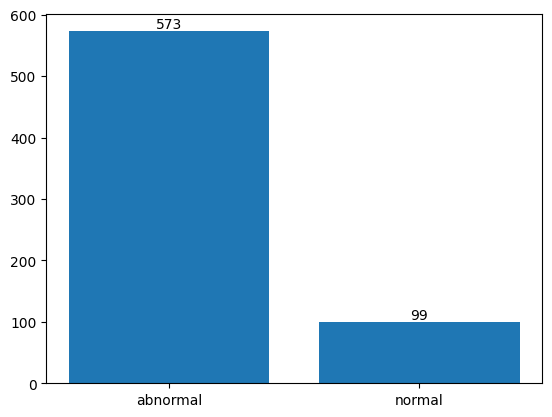

In [9]:
train_dataset.show_data_dist()

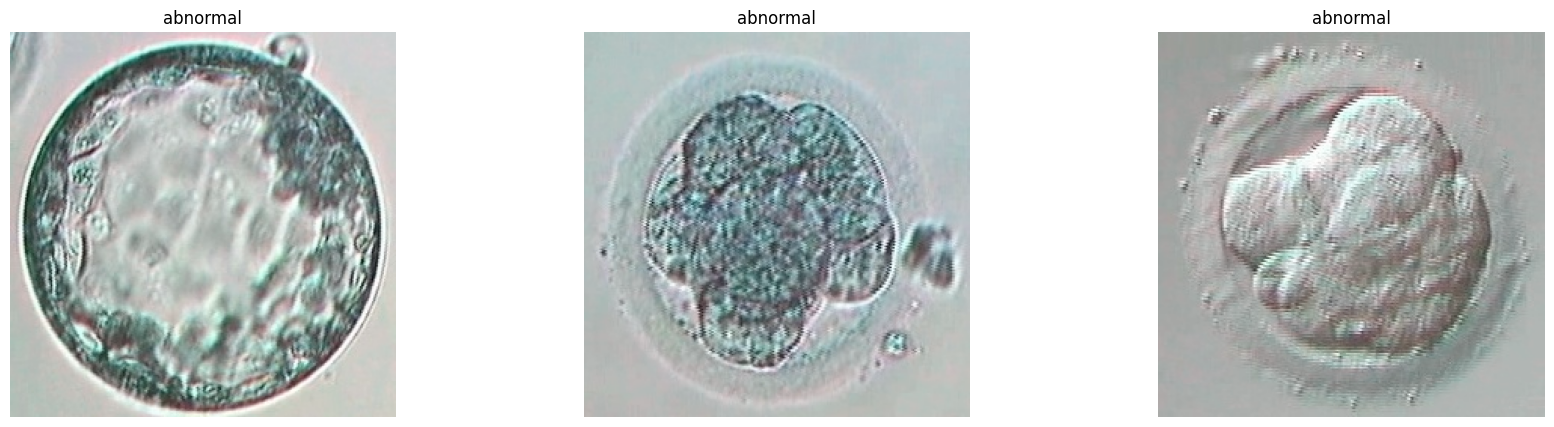

In [10]:
train_dataset.show_sample_images()

In [11]:
model     = EmbryoNet(2).to(args.device)
optimizer = optim.Adam(model.parameters(), lr = args.lr)
loss_func = nn.CrossEntropyLoss()

In [12]:
def print_metric(dtype, loss, acc, f1): 
    print(f'[{dtype}] loss : {loss:.3f}, acc : {acc:.3f}, f1 : {f1:.3f}')

for epoch in range(1, args.epochs + 1):

    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer)
    test_loss , test_acc , test_f1  = evaluate(model, test_loader)

    print(f'[{epoch}/{args.epochs}]')
    print_metric('train', train_loss, train_acc, train_f1)
    print_metric(' test', test_loss , test_acc , test_f1 )
    print('\n\n')

[1/20]
[train] loss : 0.503, acc : 0.810, f1 : 0.036
[ test] loss : 0.593, acc : 0.847, f1 : 0.000



[2/20]
[train] loss : 0.426, acc : 0.851, f1 : 0.029
[ test] loss : 0.515, acc : 0.847, f1 : 0.000



[3/20]
[train] loss : 0.420, acc : 0.853, f1 : 0.000
[ test] loss : 0.503, acc : 0.847, f1 : 0.000



[4/20]
[train] loss : 0.398, acc : 0.848, f1 : 0.017
[ test] loss : 0.435, acc : 0.847, f1 : 0.000



[5/20]
[train] loss : 0.397, acc : 0.856, f1 : 0.060
[ test] loss : 0.445, acc : 0.847, f1 : 0.000



[6/20]
[train] loss : 0.375, acc : 0.859, f1 : 0.121
[ test] loss : 0.449, acc : 0.847, f1 : 0.000



[7/20]
[train] loss : 0.398, acc : 0.854, f1 : 0.031
[ test] loss : 0.442, acc : 0.852, f1 : 0.061



[8/20]
[train] loss : 0.333, acc : 0.868, f1 : 0.237
[ test] loss : 0.458, acc : 0.790, f1 : 0.193



[9/20]
[train] loss : 0.339, acc : 0.863, f1 : 0.282
[ test] loss : 0.629, acc : 0.574, f1 : 0.247



[10/20]
[train] loss : 0.312, acc : 0.851, f1 : 0.060
[ test] loss : 0.577, acc : 